# Theano 實例：線性回歸

## 基本模型

在用 `theano` 進行線性回歸之前，先回顧一下 `theano` 的運行模式。

`theano` 是一個符號計算的數學庫，一個基本的 `theano` 結構大致如下：

- 定義符號變數
- 編譯用符號變數定義的函數，使它能夠用這些符號進行數值計算。
- 將函數應用到數據上去

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T

Using gpu device 0: GeForce GTX 850M


簡單的例子：$y = a \times b, a, b \in \mathbb{R}$

定義 $a, b, y$：

In [2]:
a = T.scalar()
b = T.scalar()

y = a * b

編譯函數：

In [3]:
multiply = theano.function(inputs=[a, b], outputs=y)

將函數運用到數據上：

In [4]:
print multiply(3, 2) # 6
print multiply(4, 5) # 20

6.0
20.0


## 線性回歸

回到線性回歸的模型，假設我們有這樣的一組數據：

In [5]:
train_X = np.linspace(-1, 1, 101)
train_Y = 2 * train_X + 1 + np.random.randn(train_X.size) * 0.33

分佈如圖：

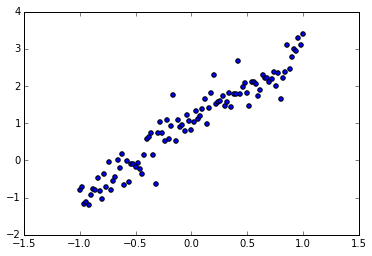

In [6]:
plt.scatter(train_X, train_Y)
plt.show()

### 定義符號變數

我們使用線性回歸的模型對其進行模擬：
$$\bar{y} = wx + b$$

首先我們定義 $x, y$：

In [7]:
X = T.scalar()
Y = T.scalar()

可以在定義時候直接給變數命名，也可以之後修改變數的名字：

In [8]:
X.name = 'x'
Y.name = 'y'

我們的模型為：

In [9]:
def model(X, w, b):
    return X * w + b

在這裡我們希望模型得到 $\bar{y}$ 與真實的 $y$ 越接近越好，常用的平方損失函數如下：
$$C = |\bar{y}-y|^2$$

有了損失函數，我們就可以使用梯度下降法來迭代參數 $w, b$ 的值，為此，我們將 $w$ 和 $b$ 設成共享變數：

In [10]:
w = theano.shared(np.asarray(0., dtype=theano.config.floatX))
w.name = 'w'
b = theano.shared(np.asarray(0., dtype=theano.config.floatX))
b.name = 'b'

定義 $\bar y$：

In [11]:
Y_bar = model(X, w, b)

theano.pp(Y_bar)

'((x * HostFromGpu(w)) + HostFromGpu(b))'

損失函數及其梯度：

In [12]:
cost = T.mean(T.sqr(Y_bar - Y))
grads = T.grad(cost=cost, wrt=[w, b])

定義梯度下降規則：

In [13]:
lr = 0.01
updates = [[w, w - grads[0] * lr],
           [b, b - grads[1] * lr]]

### 編譯訓練模型

每運行一次，參數 $w, b$ 的值就更新一次：

In [14]:
train_model = theano.function(inputs=[X,Y],
                              outputs=cost,
                              updates=updates,
                              allow_input_downcast=True)

### 將訓練函數應用到數據上

訓練模型，迭代 100 次：

In [15]:
for i in xrange(100):
    for x, y in zip(train_X, train_Y):
        train_model(x, y)

顯示結果：

1.94257426262
1.00938093662


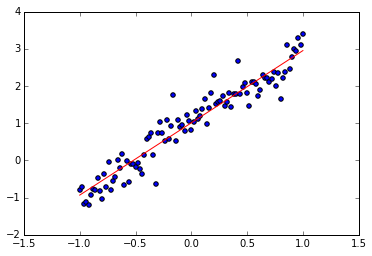

In [16]:
print w.get_value()  # 接近 2
print b.get_value()  # 接近 1

plt.scatter(train_X, train_Y)
plt.plot(train_X, w.get_value() * train_X + b.get_value(), 'r')

plt.show()